## 创建映射

In [1]:
import re
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sentence_transformers import SentenceTransformer


df = pd.read_csv('data/nodes.csv')

# 创建映射字典
node_mapping = {}
embedding_dim = 64  # 设置嵌入向量的维度
vocab = {}  # 用来存储文本的词汇表
dummy = {} # 存储虚结点

# 正则表达式模式匹配类似 "1.2 ± 0.1" 的字符串，并提取前面的数值部分
numeric_pattern = re.compile(r'^([-+]?\d*\.?\d+)\s*[±]')

for index, row in df.iterrows():
    node = row['Node']
    label = row['label']
    
    try:
        # 尝试将 node 转换为 float
        numeric_node = float(node)
        is_numeric = True
    except ValueError:
        # 尝试使用正则表达式提取类似 "1.2 ± 0.1" 的字符串中的前面的数值部分
        match = numeric_pattern.match(node)
        if match:
            numeric_node = float(match.group(1))  # 提取前面的数值部分
            is_numeric = True
        else:
            is_numeric = False

    if is_numeric:  # 如果 node 是数值字符串或数值
        node_mapping[node] = torch.tensor([numeric_node], dtype=torch.float)
    
    elif isinstance(node, str): 
        if label.startswith("dummy"):  
            if node not in dummy:
                dummy[node] = len(dummy)
            # 按照正态分布随机初始化自定义维度的向量
            node_mapping[node] = torch.tensor(np.random.normal(size=(128,)), dtype=torch.float)
        else:
            if node not in vocab and node not in dummy:
                vocab[node] = len(vocab)  # 为每个独特的文本节点分配一个索引
            node_mapping[node] = vocab[node]


# 将文本节点映射为嵌入向量
model_name = 'all-MiniLM-L6-v2'#384维
embedding_model = SentenceTransformer(model_name)

for key, value in node_mapping.items():
    if key in vocab:  # 如果是文本节点的索引
        node_mapping[key] = embedding_model.encode(key,convert_to_tensor=True)

c:\Users\86150\anaconda3\envs\dl-test\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:

for key, value in node_mapping.items():
    print(f"Node: {key}, Mapped Vector: {value.shape}")

Node: Poly[bis-(methoxytriethoxy) phosphazene] (PPZ), Mapped Vector: torch.Size([384])
Node: halide-ion-conducting gel polymer electrolyte (HGPE), Mapped Vector: torch.Size([384])
Node: Polytetrahydrofuran-hexamethylene diisocyanate-2-hydroxyethyl disulfide (PTMG-HDI-BHDS), Mapped Vector: torch.Size([384])
Node: Polytetrahydrofuran-hexamethylene diisocyanate (PTMG-HDI), Mapped Vector: torch.Size([384])
Node: PVCM-GPE, Mapped Vector: torch.Size([384])
Node: polymer hetero-electrolyte (PHE), Mapped Vector: torch.Size([384])
Node: bis(2-methoxyethyl) ether (diglyme), Mapped Vector: torch.Size([384])
Node: EP100, Mapped Vector: torch.Size([384])
Node: EP70, Mapped Vector: torch.Size([384])
Node: EP60, Mapped Vector: torch.Size([384])
Node: EP55, Mapped Vector: torch.Size([384])
Node: EP50, Mapped Vector: torch.Size([384])
Node: EP45, Mapped Vector: torch.Size([384])
Node: EP40, Mapped Vector: torch.Size([384])
Node: P(IL-OFHDODA-VEC), Mapped Vector: torch.Size([384])
Node: LPE@Ni-DMF, Mapp

## 整理成图结构

In [79]:
import networkx as nx

# 加载数据
node_data = pd.read_csv('data/nodes.csv')
edge_data = pd.read_csv('data/edges.csv') 

# 创建图结构
G = nx.Graph()

# 添加节点和它们的嵌入特征
for _, row in node_data.iterrows():
    node_id = row['Node']
    node_label = row['label']

    G.add_node(node_id, feature=node_mapping[node_id],label = node_label)

# 添加边及其特征
for _, row in edge_data.iterrows():
    source = row['Source']
    target = row['Target']
    label = row['label']
    condition = row['condition']
    
    # 添加边并包含边的特征
    G.add_edge(source, target, label=label, condition=condition)

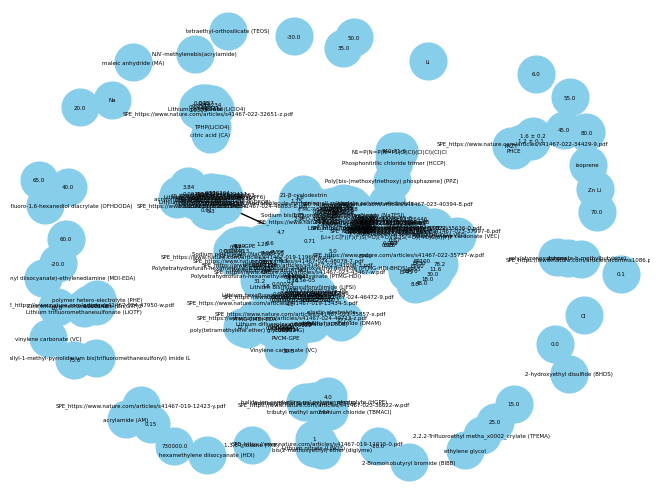

In [80]:
# 绘制图
pos = nx.spring_layout(G)  # 使用spring布局
# 绘制节点和边
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=4)

In [89]:
# 检测孤立节点
isolates = list(nx.isolates(G))

if isolates:
    print("孤立节点如下：")
    for isolate in isolates:
        print(isolate)
else:
    print("图中没有孤立节点。")

孤立节点如下：
1,3,5-trioxane (TXE)
hexamethylene diisocyanate (HDI)
1-allyl-1-methyl-pyrrolidinium bis(trifluoromethanesulfonyl) imide IL
maleic anhydride (MA)
2-Bromoisobutyryl bromide (BIBB)
4,4’-methylene diphenyl diisocyanate)-ethylenediamine (MDI-EDA)
tetraethyl-orthosilicate (TEOS)
acrylamide (AM)
isoprene
2-hydroxyethyl disulfide (BHDS)
2,2,3,3,4,4,5,5-octafluoro-1,6-hexanediol diacrylate (OFHDODA)
vinylene carbonate (VC)
2,2,2-Trifluoroethyl metha_x0002_crylate (TFEMA)
ethylene glycol
N,N′-methylenebis(acrylamide)
0.1
60.0
730000.0
80.0
0.15
15.0
6.0
45.0
Cl
Li
Zn Li
Na
25.0
-20.0
40.0
50.0
70.0
-30.0
0.0
-10.0
75.0
65.0
55.0
35.0
10.0
20.0
SPE_https://www.nature.com/articles/s41467-019-12423-y.pdf


## 简单聚合后聚类

In [82]:
import torch

# 定义目标维度
target_dim = 384

# 对于以"SPE"开头的节点进行邻居特征聚合
for node in G.nodes():
    if node.startswith("SPE"):
        neighbors = list(G.neighbors(node))
        if neighbors:
            neighbor_features = []
            for neighbor in neighbors:
                if 'feature' in G.nodes[neighbor]:
                    feature = G.nodes[neighbor]['feature']
                    # 如果特征维度小于目标维度，则进行填充
                    if feature.size(0) < target_dim:
                        padding = torch.zeros(target_dim - feature.size(0))
                        feature = torch.cat((feature, padding), dim=0)
                    neighbor_features.append(feature)
                else:
                    print(f"Warning: Node {neighbor} does not have 'feature' attribute.")
            
            if neighbor_features:
                aggregated_feature = torch.mean(torch.stack(neighbor_features), dim=0)
                G.nodes[node]['aggregated_feature'] = aggregated_feature
            else:
                G.nodes[node]['aggregated_feature'] = G.nodes[node]['feature']
        else:
            G.nodes[node]['aggregated_feature'] = G.nodes[node]['feature']



In [21]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# 假设已经有之前的图结构G

# 提取聚合后的特征进行聚类分析
aggregated_features = [G.nodes[node]['aggregated_feature'] for node in G.nodes() if node.startswith("SPE")]
# 遍历每个特征，检查其维度，如果不是目标维度则填充
for i, feature in enumerate(aggregated_features):
    print(f"Original feature shape: {feature.shape}")
    if feature.shape[0] != target_dim:
        padding = torch.zeros(target_dim - feature.shape[0])
        aggregated_features[i] = torch.cat((feature, padding), dim=0)
    print(f"Updated feature shape: {aggregated_features[i].shape}")


Original feature shape: torch.Size([384])
Updated feature shape: torch.Size([384])
Original feature shape: torch.Size([384])
Updated feature shape: torch.Size([384])
Original feature shape: torch.Size([384])
Updated feature shape: torch.Size([384])
Original feature shape: torch.Size([128])
Updated feature shape: torch.Size([384])
Original feature shape: torch.Size([384])
Updated feature shape: torch.Size([384])
Original feature shape: torch.Size([384])
Updated feature shape: torch.Size([384])
Original feature shape: torch.Size([384])
Updated feature shape: torch.Size([384])
Original feature shape: torch.Size([384])
Updated feature shape: torch.Size([384])
Original feature shape: torch.Size([384])
Updated feature shape: torch.Size([384])
Original feature shape: torch.Size([384])
Updated feature shape: torch.Size([384])
Original feature shape: torch.Size([384])
Updated feature shape: torch.Size([384])
Original feature shape: torch.Size([384])
Updated feature shape: torch.Size([384])
Orig

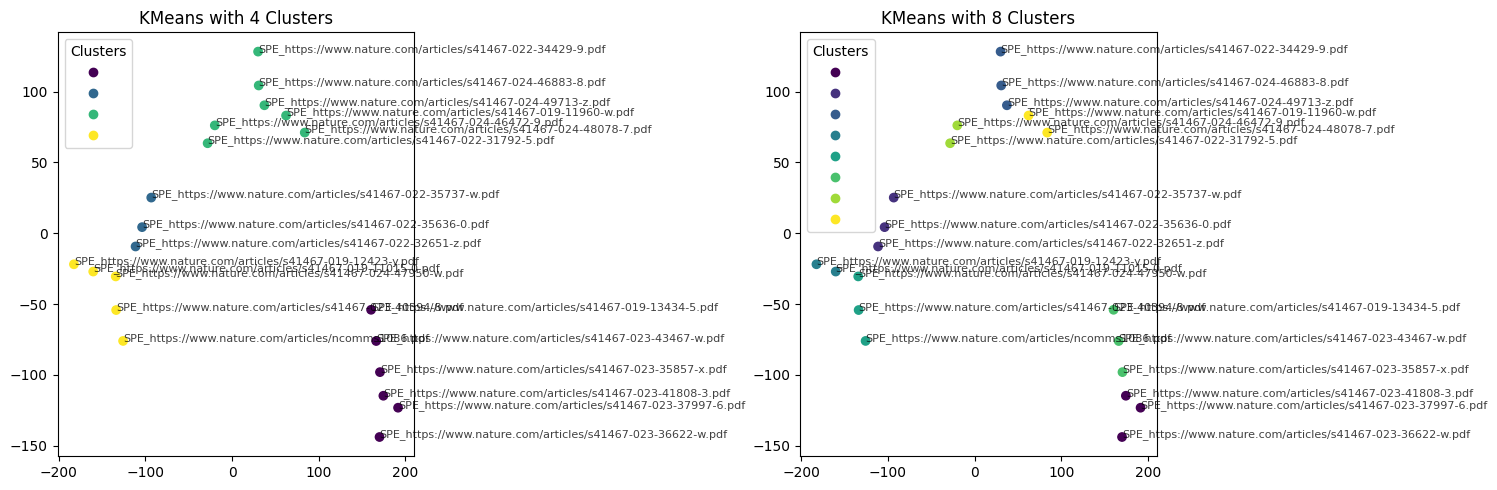

In [34]:
# 将这些张量转换为NumPy数组，以便于后续的聚类分析
aggregated_features_np = torch.stack(aggregated_features).numpy()

tsne = TSNE(n_components=2, random_state=0,perplexity=2)
features_2d = tsne.fit_transform(aggregated_features_np)

# 尝试不同的聚类数量
n_clusters_options = [4,8]
kmeans_results = {}

for n_clusters in n_clusters_options:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(features_2d)
    kmeans_results[n_clusters] = labels

# 可视化聚类结果
fig, axes = plt.subplots(1, len(n_clusters_options), figsize=(15, 5))

spe_nodes = [node for node in G.nodes() if node.startswith("SPE")]

for i, n_clusters in enumerate(n_clusters_options):
    ax = axes[i]
    ax.set_title(f"KMeans with {n_clusters} Clusters")
    scatter = ax.scatter(features_2d[:, 0], features_2d[:, 1], c=kmeans_results[n_clusters], cmap='viridis')
    ax.legend(handles=scatter.legend_elements()[0], title="Clusters")
    for j, node in enumerate(spe_nodes):
        ax.annotate(node, (features_2d[j, 0], features_2d[j, 1]), fontsize=8, alpha=0.75)

plt.tight_layout()
plt.show()

In [35]:
# 打印图中节点的名字和相关信息
print("Nodes and their associated data:")
for node in spe_nodes:
    cluster_label = kmeans_results[4][spe_nodes.index(node)]  # 假设你想打印4个聚类的结果
    print(f"Node: {node}, Cluster: {cluster_label}")

Nodes and their associated data:
Node: SPE_https://www.nature.com/articles/ncomms1086.pdf, Cluster: 3
Node: SPE_https://www.nature.com/articles/s41467-019-11015-0.pdf, Cluster: 3
Node: SPE_https://www.nature.com/articles/s41467-019-11960-w.pdf, Cluster: 2
Node: SPE_https://www.nature.com/articles/s41467-019-12423-y.pdf, Cluster: 3
Node: SPE_https://www.nature.com/articles/s41467-019-13434-5.pdf, Cluster: 0
Node: SPE_https://www.nature.com/articles/s41467-022-31792-5.pdf, Cluster: 2
Node: SPE_https://www.nature.com/articles/s41467-022-32651-z.pdf, Cluster: 1
Node: SPE_https://www.nature.com/articles/s41467-022-34429-9.pdf, Cluster: 2
Node: SPE_https://www.nature.com/articles/s41467-022-35636-0.pdf, Cluster: 1
Node: SPE_https://www.nature.com/articles/s41467-022-35737-w.pdf, Cluster: 1
Node: SPE_https://www.nature.com/articles/s41467-023-35857-x.pdf, Cluster: 0
Node: SPE_https://www.nature.com/articles/s41467-023-36622-w.pdf, Cluster: 0
Node: SPE_https://www.nature.com/articles/s41467-02

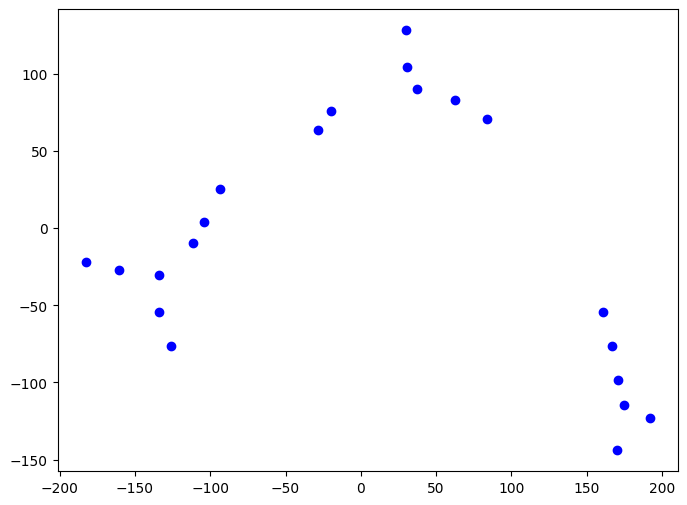

In [31]:
# 可视化t-SNE降维结果
plt.figure(figsize=(8, 6))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c='blue', marker='o')


## 考虑不同节点特征

In [104]:
from sklearn.decomposition import PCA
import torch
import torch.nn.functional as F
import networkx as nx
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


for node in G.nodes():
    if node.startswith("SPE"):
        # 聚合邻居节点特征
        neighbor_features = defaultdict(lambda: defaultdict(list))

        for neighbor in G.neighbors(node):
            try:
                feature = node_mapping[neighbor]
                label = G.nodes[neighbor].get('label', 'No label')
                # 将特征按标签和维度进行分组
                neighbor_features[label][feature.size(0)].append(feature)
            except KeyError:
                pass  # 如果节点不存在或特征未定义，则跳过

        # 对相同标签、相同维度的特征进行平均聚合
        aggregated_features = defaultdict(list)

        for label, features_by_dim in neighbor_features.items():
            for dim, features in features_by_dim.items():
                if len(features) > 0:
                    aggregated_feature = torch.mean(torch.stack(features), dim=0)
                    aggregated_features[label].append(aggregated_feature)


        if aggregated_features:
            # 提取并拼接 Polymer.Name 和 Salts.Name 的特征
            polymer_and_salts_features = []
            if 'Polymer.Name' in aggregated_features:
                polymer_and_salts_features.append(torch.cat(aggregated_features['Polymer.Name'], dim=0))
            if 'Salts.Name' in aggregated_features:
                polymer_and_salts_features.append(torch.cat(aggregated_features['Salts.Name'], dim=0))
            
            combined_polymer_salts_feature = torch.cat(polymer_and_salts_features, dim=0)
            print(f"Combined Polymer and Salts feature shape: {combined_polymer_salts_feature.shape}")

            # 对其他特征作为数值处理，进行对数变换，并将其应用到拼接后的向量上
            transformation_factors = {
                'Conductivity.Value': 0.5,
                'Electrochemical_Window.Value': 0.3,
                'Transference_Number.Value': 0.2
            }
            
            for label, factor in transformation_factors.items():
                if label in aggregated_features and aggregated_features[label]:
                    value = aggregated_features[label][0].item()  
                    if value > 0:
                        scaled_value = value * 1e8 if value < 1 else value  # 对小值放大
                        transformed_value = torch.log1p(torch.tensor(scaled_value))  # 使用 log1p
                        transformed_value = max(transformed_value, torch.tensor(1e-6))
                    # 
                    combined_polymer_salts_feature *= (1 + factor * transformed_value) 
                print(f"Label: {label}, Original Value: {value}, Transformed Value: {transformed_value.item()}") 
            
            # 标准化处理
            combined_polymer_salts_feature = combined_polymer_salts_feature.unsqueeze(0)

            scaler = StandardScaler()
            normalized_feature = torch.tensor(scaler.fit_transform(combined_polymer_salts_feature), dtype=torch.float32).squeeze(0)

            node_mapping[node] = normalized_feature

            print(f"Final transformed and normalized feature shape: {normalized_feature.shape}\n")

# 将更新后的特征存储回图G中
for node in G.nodes():
    try:
        G.nodes[node]['feature'] = node_mapping[node]
    except KeyError:
        pass  # 如果节点不存在或特征未定义，则跳过

Combined Polymer and Salts feature shape: torch.Size([384])
Label: Conductivity.Value, Original Value: 0.44999998807907104, Transformed Value: 17.622173309326172
Label: Electrochemical_Window.Value, Original Value: 0.44999998807907104, Transformed Value: 17.622173309326172
Label: Transference_Number.Value, Original Value: 0.44999998807907104, Transformed Value: 17.622173309326172
Final transformed and normalized feature shape: torch.Size([384])

Combined Polymer and Salts feature shape: torch.Size([768])
Label: Conductivity.Value, Original Value: 0.44999998807907104, Transformed Value: 17.622173309326172
Label: Electrochemical_Window.Value, Original Value: 0.44999998807907104, Transformed Value: 17.622173309326172
Label: Transference_Number.Value, Original Value: 0.44999998807907104, Transformed Value: 17.622173309326172
Final transformed and normalized feature shape: torch.Size([768])

Combined Polymer and Salts feature shape: torch.Size([768])
Label: Conductivity.Value, Original Valu

c:\Users\86150\anaconda3\envs\dl-test\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


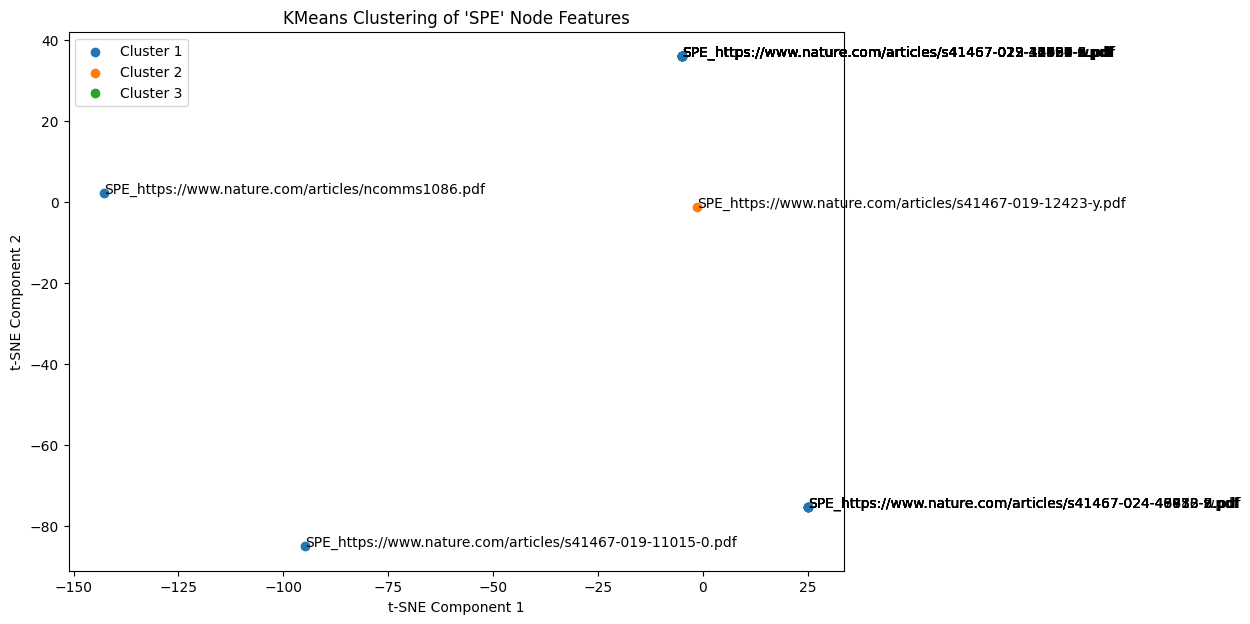

In [118]:


# 提取以 "SPE" 开头的节点特征进行聚类
spe_features = []
spe_labels = []

for node in G.nodes():
    if node.startswith("SPE"):
        spe_features.append(G.nodes[node]['feature'].detach())
        spe_labels.append(node)

# 1. 确定最长的特征长度
max_length = max(len(f) for f in spe_features)

# 2. 对齐所有特征向量的长度
aligned_spe_features = []
for feature in spe_features:
    if len(feature) < max_length:
        feature = F.pad(feature, (0, max_length - len(feature)), "constant", 0)
    aligned_spe_features.append(feature)

spe_features_array = torch.stack(aligned_spe_features)

# 使用线性层进行特征降维
linear_layer = nn.Linear(in_features=spe_features_array.shape[1], out_features=256)
spe_features_reduced = linear_layer(spe_features_array).detach().numpy()

# 使用KMeans进行聚类
num_clusters = 3 
kmeans = KMeans(n_clusters=num_clusters, random_state=30)
cluster_labels = kmeans.fit_predict(spe_features_reduced)


tsne = TSNE(n_components=2, random_state=30, perplexity=10)
reduced_features = tsne.fit_transform(spe_features_reduced)


plt.figure(figsize=(10, 7))
for i in range(num_clusters):
    plt.scatter(reduced_features[cluster_labels == i, 0], reduced_features[cluster_labels == i, 1], label=f'Cluster {i+1}')


for i, label in enumerate(spe_labels):
    plt.annotate(label, (reduced_features[i, 0], reduced_features[i, 1]))

plt.title("KMeans Clustering of 'SPE' Node Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()


clusters = defaultdict(list)
for label, cluster in zip(spe_labels, cluster_labels):
    clusters[cluster].append(label)

for cluster, nodes in clusters.items():
    print(f"Cluster {cluster}:")
    for node in nodes:
        print(f"  {node}")

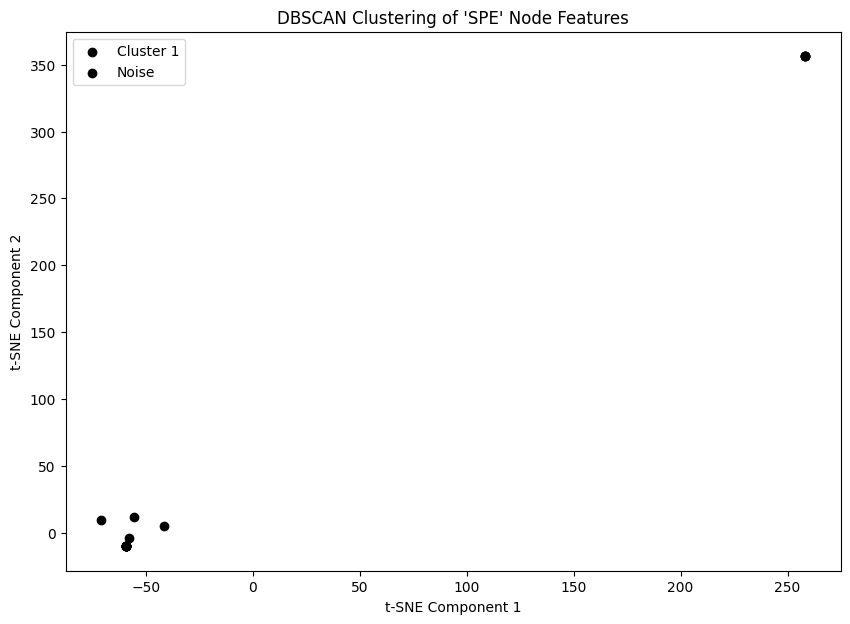

Cluster 1:
  SPE_https://www.nature.com/articles/ncomms1086.pdf
  SPE_https://www.nature.com/articles/s41467-019-11015-0.pdf
  SPE_https://www.nature.com/articles/s41467-019-11960-w.pdf
  SPE_https://www.nature.com/articles/s41467-019-13434-5.pdf
  SPE_https://www.nature.com/articles/s41467-022-31792-5.pdf
  SPE_https://www.nature.com/articles/s41467-022-32651-z.pdf
  SPE_https://www.nature.com/articles/s41467-022-34429-9.pdf
  SPE_https://www.nature.com/articles/s41467-022-35636-0.pdf
  SPE_https://www.nature.com/articles/s41467-022-35737-w.pdf
  SPE_https://www.nature.com/articles/s41467-023-35857-x.pdf
  SPE_https://www.nature.com/articles/s41467-023-36622-w.pdf
  SPE_https://www.nature.com/articles/s41467-023-37997-6.pdf
  SPE_https://www.nature.com/articles/s41467-023-40394-8.pdf
  SPE_https://www.nature.com/articles/s41467-023-41808-3.pdf
  SPE_https://www.nature.com/articles/s41467-023-43467-w.pdf
  SPE_https://www.nature.com/articles/s41467-024-46472-9.pdf
  SPE_https://www.nat

In [120]:
from sklearn.cluster import DBSCAN
# 使用DBSCAN进行聚类
dbscan = DBSCAN(eps=0.5, min_samples=5)  # 调整 eps 和 min_samples 以得到更好的聚类结果
cluster_labels = dbscan.fit_predict(spe_features_reduced)

# 使用t-SNE将特征降至2维，以便于可视化
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
reduced_features = tsne.fit_transform(spe_features_reduced)

# 可视化聚类结果
plt.figure(figsize=(10, 7))
unique_labels = set(cluster_labels)

for label in unique_labels:
    if label == -1:
        # -1表示噪声点
        color = 'k'
        label_name = 'Noise'
    else:
        color = plt.cm.nipy_spectral(float(label) / len(unique_labels))
        label_name = f'Cluster {label + 1}'
    plt.scatter(reduced_features[cluster_labels == label, 0],
                reduced_features[cluster_labels == label, 1],
                color=color, label=label_name)

plt.title("DBSCAN Clustering of 'SPE' Node Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

# 打印每个节点的聚类结果
clusters = defaultdict(list)
for label, cluster in zip(spe_labels, cluster_labels):
    clusters[cluster].append(label)

for cluster, nodes in clusters.items():
    if cluster == -1:
        print(f"Noise:")
    else:
        print(f"Cluster {cluster + 1}:")
    for node in nodes:
        print(f"  {node}")


In [97]:
for node in G.nodes():
    if node.startswith("SPE"):
        print(f"中心节点: {node},特征向量: {node_mapping[node].shape}")
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            try:
                label = G.nodes[neighbor].get('label', 'No label') 
                print(f" - 邻居节点: {neighbor}, 特征向量: {node_mapping[neighbor].shape},类别:{label}")
            except KeyError:
                pass
        print("\n")  # 添加换行以区分不同的中心节点

中心节点: SPE_https://www.nature.com/articles/ncomms1086.pdf,特征向量: torch.Size([384])
 - 邻居节点: poly(styrenesulphonate-b-methylbutylene), 特征向量: torch.Size([384]),类别:Polymer.Name


中心节点: SPE_https://www.nature.com/articles/s41467-019-11015-0.pdf,特征向量: torch.Size([768])
 - 邻居节点: bis(2-methoxyethyl) ether (diglyme), 特征向量: torch.Size([384]),类别:Polymer.Name
 - 邻居节点: Lithium nitrate (LiNO3), 特征向量: torch.Size([384]),类别:Salts.Name


中心节点: SPE_https://www.nature.com/articles/s41467-019-11960-w.pdf,特征向量: torch.Size([768])
 - 邻居节点: ANs–GPE, 特征向量: torch.Size([384]),类别:Polymer.Name
 - 邻居节点: GFs–GPE, 特征向量: torch.Size([384]),类别:Polymer.Name
 - 邻居节点: Sodium perchlorate (NaClO4), 特征向量: torch.Size([384]),类别:Salts.Name
 - 邻居节点: 0.000713, 特征向量: torch.Size([1]),类别:Conductivity.Value
 - 邻居节点: 4.8, 特征向量: torch.Size([1]),类别:Electrochemical_Window.Value
 - 邻居节点: 0.37, 特征向量: torch.Size([1]),类别:Transference_Number.Value
 - 邻居节点: 0.000946, 特征向量: torch.Size([1]),类别:Conductivity.Value
 - 邻居节点: 0.29, 特征向量: torch.Size([1])